In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
from datetime import timedelta
import matplotlib.pyplot as plt

# === CONFIGURATION ===
USE_THIS_CSV_FOR_TRAINING = False  # True: train and save; False: load and predict
MODEL_DIR = 'models'
OUTPUT_DIR = 'output'
SIGNATURE_FILE = f'{MODEL_DIR}/model_training_signature.csv'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

HISTORICAL_CSV = 'TTI Model Testing - Blank Historical (1).csv'
REVIEWS_CSV = 'TTI Model Testing - Blank - Review.csv'

def get_latest_version():
    files = [f for f in os.listdir(MODEL_DIR) if f.startswith('blank_rating_model_v')]
    if not files:
        return 0
    versions = [int(f.split('_v')[-1].split('.joblib')[0]) for f in files]
    return max(versions)

# === RANDOMIZED SPLIT FUNCTION ===
def randomized_monthly_split(total, n_months, max_variation=0.15):
    if total == 0 or n_months == 0:
        return [0] * n_months
    mean = total / n_months
    perturb = np.random.uniform(-max_variation, max_variation, size=n_months)
    temp = mean * (1 + perturb)
    temp = temp * (total / temp.sum())
    vals = np.round(temp).astype(int)
    diff = total - vals.sum()
    for i in range(abs(diff)):
        idx = i % n_months
        vals[idx] += int(np.sign(diff))
    return vals.tolist()

# === COLUMN RENAMING ===
REVIEWS_COL_MAP = {'Product Name':'Product_Name','review date':'review_date'}
HISTORICAL_COL_MAP = {'Product Name':'Product_Name','Snapshot Date':'Snapshot_Date','Total 5 Star':'Total_5_Star',
    'Total 4 Star':'Total_4_Star','Total 3 Star':'Total_3_Star','Total 2 Star':'Total_2_Star','Total 1 Star':'Total_1_Star',
    'Total all Ratings':'Total_all_reviews','Blank Ratings':'Blank_Ratings','Scraped Reviews':'Scraped_Reviews'}

# === 1. Load Data ===
reviews = pd.read_csv(REVIEWS_CSV)
historical = pd.read_csv(HISTORICAL_CSV)
reviews.columns = reviews.columns.str.strip()
historical.columns = historical.columns.str.strip()
reviews = reviews.rename(columns=REVIEWS_COL_MAP)
historical = historical.rename(columns=HISTORICAL_COL_MAP)
reviews['review_date'] = pd.to_datetime(reviews['review_date'])
historical['Snapshot_Date'] = pd.to_datetime(historical['Snapshot_Date'])

# === 2. Delta Calculation ===
written_reviews_count = reviews.groupby(['Product_Name', 'review_date']).size().reset_index(name='Scraped_Reviews')

def get_scraped_reviews_in_period(product, prev_date, curr_date):
    mask = (
        (written_reviews_count['Product_Name'] == product) &
        (written_reviews_count['review_date'] > prev_date) &
        (written_reviews_count['review_date'] <= curr_date)
    )
    return written_reviews_count.loc[mask, 'Scraped_Reviews'].sum()

deltas = []
for product, group in historical.groupby('Product_Name'):
    group = group.sort_values('Snapshot_Date').reset_index(drop=True)
    for i in range(1, len(group)):
        prev = group.loc[i-1]
        curr = group.loc[i]
        delta_total = curr['Total_all_reviews'] - prev['Total_all_reviews']
        delta_scraped = get_scraped_reviews_in_period(product, prev['Snapshot_Date'], curr['Snapshot_Date'])
        deltas.append({
            'Product_Name': product,
            'Start_Date': prev['Snapshot_Date'],
            'End_Date': curr['Snapshot_Date'],
            'Delta_Blank_True': max(delta_total - delta_scraped, 0),
            'Total_all_reviews': curr['Total_all_reviews'],
            'Total_5_Star': curr['Total_5_Star'],
            'Total_4_Star': curr['Total_4_Star'],
            'Total_3_Star': curr['Total_3_Star'],
            'Total_2_Star': curr['Total_2_Star'],
            'Total_1_Star': curr['Total_1_Star'],
        })
delta_df = pd.DataFrame(deltas)

# === 3. Monthly Dataset Creation (Randomized raw split for realistic even bars) ===
all_monthly_rows = []
for _, row in delta_df.iterrows():
    product = row['Product_Name']
    start = row['Start_Date']
    end = row['End_Date']
    total_blanks = int(row['Delta_Blank_True'])
    if total_blanks == 0:
        continue
    months = pd.date_range(start.to_period('M').to_timestamp(), end.to_period('M').to_timestamp(), freq='MS')
    n_months = len(months)
    monthly_counts = randomized_monthly_split(total_blanks, n_months, max_variation=0.15)
    for idx, (month, count) in enumerate(zip(months, monthly_counts)):
        all_monthly_rows.append({
            'Product_Name': product,
            'Month': month,
            'Total_all_reviews': row['Total_all_reviews'],
            'Total_5_Star': row['Total_5_Star'],
            'Total_4_Star': row['Total_4_Star'],
            'Total_3_Star': row['Total_3_Star'],
            'Total_2_Star': row['Total_2_Star'],
            'Total_1_Star': row['Total_1_Star'],
            'Blank_Review_Raw': count,
            'Month_Index': idx,
            'Delta_Period': f"{row['Start_Date'].strftime('%Y-%m-%d')} → {row['End_Date'].strftime('%Y-%m-%d')}"
        })
monthly_df = pd.DataFrame(all_monthly_rows)

# === 4. Exclude Already-Trained Product+Delta_Period (Signature) ===
already_trained = set()
if os.path.exists(SIGNATURE_FILE):
    sig_df = pd.read_csv(SIGNATURE_FILE)
    already_trained = set(zip(sig_df['Product_Name'], sig_df['Delta_Period']))
    print(f"Excluding {len(already_trained)} previously trained product+delta combinations from training.")

monthly_df['in_signature'] = monthly_df.apply(lambda x: (x['Product_Name'], x['Delta_Period']) in already_trained, axis=1)

# === 5. Model Preparation (Train or Load) ===
feature_cols = [
    'Total_all_reviews', 'Total_5_Star', 'Total_4_Star',
    'Total_3_Star', 'Total_2_Star', 'Total_1_Star', 'Month_Index'
]
model_version = get_latest_version()
model_path = f'{MODEL_DIR}/blank_rating_model_v{model_version}.joblib'
model = None

if USE_THIS_CSV_FOR_TRAINING:
    # Exclude previously trained product+delta
    train_monthly_df = monthly_df[~monthly_df['in_signature']].copy()
    # Smoothing (3-mo rolling, sum-preserved) for target
    records = []
    for (product, delta_period), group in train_monthly_df.groupby(['Product_Name', 'Delta_Period']):
        group = group.sort_values('Month')
        rolling = group['Blank_Review_Raw'].rolling(window=3, min_periods=1, center=True).mean()
        rolling = rolling * group['Blank_Review_Raw'].sum() / rolling.sum()
        group['Blank_Review_Smoothed'] = np.round(rolling).astype(int)
        records.append(group)
    if records:
        train_monthly_df = pd.concat(records, ignore_index=True)
    else:
        train_monthly_df = pd.DataFrame(columns=monthly_df.columns.tolist() + ['Blank_Review_Smoothed'])

    # Remove duplicates for safety
    dedup_cols = feature_cols + ['Month', 'Blank_Review_Smoothed']
    before = len(train_monthly_df)
    train_monthly_df = train_monthly_df.drop_duplicates(subset=dedup_cols)
    after = len(train_monthly_df)
    if before != after:
        print(f"Deduplication: Removed {before - after} duplicate records before training.")

    # Train model if there are new rows
    if not train_monthly_df.empty:
        X = train_monthly_df[feature_cols]
        y = train_monthly_df['Blank_Review_Smoothed']
        model_version += 1
        model = RandomForestRegressor(n_estimators=200, random_state=42)
        model.fit(X, y)
        joblib.dump(model, f'{MODEL_DIR}/blank_rating_model_v{model_version}.joblib')
        print(f"Model trained and saved as blank_rating_model_v{model_version}.joblib")
        # Save/append new signature rows
        new_sig_df = train_monthly_df[['Product_Name', 'Delta_Period']].drop_duplicates()
        if os.path.exists(SIGNATURE_FILE):
            old_sig_df = pd.read_csv(SIGNATURE_FILE)
            sig_df_out = pd.concat([old_sig_df, new_sig_df], ignore_index=True).drop_duplicates()
        else:
            sig_df_out = new_sig_df
        sig_df_out.to_csv(SIGNATURE_FILE, index=False)
        print(f"Updated model training signature at: {SIGNATURE_FILE}")
    else:
        # If no new products, just load the latest model if it exists
        if os.path.exists(model_path):
            model = joblib.load(model_path)
            print(f"Loaded model {model_path} (no new products to train)")
        else:
            print("WARNING: No previous model found and nothing to train!")

else:
    # Always attempt to load model if available
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"Loaded model {model_path}")
    else:
        print("WARNING: No model found; using randomized monthly distribution instead.")

# === 6. Monthly Prediction (Model or Randomized) ===
pred_rows = []
for _, row in delta_df.iterrows():
    product = row['Product_Name']
    start = row['Start_Date']
    end = row['End_Date']
    delta_period = f"{start.strftime('%Y-%m-%d')} → {end.strftime('%Y-%m-%d')}"
    total_blanks = int(row['Delta_Blank_True'])
    if total_blanks == 0:
        continue
    months = pd.date_range(start.to_period('M').to_timestamp(), end.to_period('M').to_timestamp(), freq='MS')
    n_months = len(months)
    features = np.array([[
        row['Total_all_reviews'],
        row['Total_5_Star'],
        row['Total_4_Star'],
        row['Total_3_Star'],
        row['Total_2_Star'],
        row['Total_1_Star'],
        idx
    ] for idx in range(n_months)])
    # Use model only if this product/delta is not in signature or we're not retraining
    use_model = model is not None and ((product, delta_period) in already_trained or USE_THIS_CSV_FOR_TRAINING == False)
    if use_model:
        pred = model.predict(features)
        pred = np.maximum(pred, 0)
        pred = pred * (total_blanks / pred.sum()) if pred.sum() > 0 else np.zeros_like(pred)
        pred = np.round(pred).astype(int)
        diff = total_blanks - pred.sum()
        for i in range(abs(diff)):
            pred[i % len(pred)] += int(np.sign(diff))
    else:
        pred = np.array(randomized_monthly_split(total_blanks, n_months, max_variation=0.15))
    # Always create a randomized "raw" for baseline visualization
    raw_counts = np.array(randomized_monthly_split(total_blanks, n_months, max_variation=0.15))
    for idx, (month, count_raw, count_pred) in enumerate(zip(months, raw_counts, pred)):
        pred_rows.append({
            'Product_Name': product,
            'Month': month,
            'Total_all_reviews': row['Total_all_reviews'],
            'Total_5_Star': row['Total_5_Star'],
            'Total_4_Star': row['Total_4_Star'],
            'Total_3_Star': row['Total_3_Star'],
            'Total_2_Star': row['Total_2_Star'],
            'Total_1_Star': row['Total_1_Star'],
            'Blank_Review_Raw': count_raw,
            'Blank_Review_ModelPred': count_pred,
            'Month_Index': idx,
            'Delta_Period': delta_period
        })
monthly_pred_df = pd.DataFrame(pred_rows)

# === 7. Smoothing (3-mo rolling, sum-preserved) ===
records = []
for (product, delta_period), group in monthly_pred_df.groupby(['Product_Name', 'Delta_Period']):
    group = group.sort_values('Month')
    rolling_raw = group['Blank_Review_Raw'].rolling(window=3, min_periods=1, center=True).mean()
    rolling_raw = rolling_raw * group['Blank_Review_Raw'].sum() / rolling_raw.sum() if rolling_raw.sum() else rolling_raw
    group['Blank_Review_RawSmoothed'] = np.round(rolling_raw.fillna(0)).astype(int)
    rolling_pred = group['Blank_Review_ModelPred'].rolling(window=3, min_periods=1, center=True).mean()
    rolling_pred = rolling_pred * group['Blank_Review_ModelPred'].sum() / rolling_pred.sum() if rolling_pred.sum() else rolling_pred
    group['Blank_Review_ModelSmoothed'] = np.round(rolling_pred.fillna(0)).astype(int)
    records.append(group)
monthly_pred_df = pd.concat(records, ignore_index=True)

# === 8. CSV Outputs ===
monthly_pred_df[['Product_Name', 'Delta_Period', 'Month', 'Blank_Review_Raw']].to_csv(
    f'{OUTPUT_DIR}/blank_review_trend_raw.csv', index=False)
monthly_pred_df[['Product_Name', 'Delta_Period', 'Month', 'Blank_Review_ModelPred']].to_csv(
    f'{OUTPUT_DIR}/blank_review_trend_modelpred.csv', index=False)
monthly_pred_df[['Product_Name', 'Delta_Period', 'Month', 'Blank_Review_RawSmoothed']].to_csv(
    f'{OUTPUT_DIR}/blank_review_trend_raw_3mo_smooth.csv', index=False)
monthly_pred_df[['Product_Name', 'Delta_Period', 'Month', 'Blank_Review_ModelSmoothed']].to_csv(
    f'{OUTPUT_DIR}/blank_review_trend_modelpred_3mo_smooth.csv', index=False)

print('Raw trend CSV saved to:', f'{OUTPUT_DIR}/blank_review_trend_raw.csv')
print('Model-predicted trend CSV saved to:', f'{OUTPUT_DIR}/blank_review_trend_modelpred.csv')
print('Raw 3-month rolling CSV saved to:', f'{OUTPUT_DIR}/blank_review_trend_raw_3mo_smooth.csv')
print('Model-predicted 3-month rolling CSV saved to:', f'{OUTPUT_DIR}/blank_review_trend_modelpred_3mo_smooth.csv')

# === 9. Evaluation (only when training, but can extend to prediction for analysis)
if model is not None and USE_THIS_CSV_FOR_TRAINING:
    y_true = monthly_pred_df['Blank_Review_RawSmoothed']
    y_pred = monthly_pred_df['Blank_Review_ModelSmoothed']
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    acc = 100 - mape

    eval_df = pd.DataFrame({
        "Product_Name": monthly_pred_df["Product_Name"],
        "Delta_Period": monthly_pred_df["Delta_Period"],
        "Month": monthly_pred_df["Month"],
        "True_Blank": y_true,
        "Pred_Blank": y_pred,
        "Abs_Error": (y_true - y_pred).abs(),
        "Percent_Error": 100 * ((y_true - y_pred).abs() / (y_true + 1e-8))
    })

    print("\n=== Per-row evaluation ===")
    print(eval_df)

    eval_df.to_csv(f"{OUTPUT_DIR}/model_eval_per_month.csv", index=False)
    print(f"Per-month evaluation CSV saved to: {OUTPUT_DIR}/model_eval_per_month.csv")

    metrics_df = pd.DataFrame([{
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE (%)": mape,
        "Accuracy (%)": acc
    }])
    print("\n=== Summary metrics ===")
    print(metrics_df)
    metrics_df.to_csv(f"{OUTPUT_DIR}/model_eval_summary.csv", index=False)
    print(f"Summary metrics CSV saved to: {OUTPUT_DIR}/model_eval_summary.csv")


Loaded model models/blank_rating_model_v1.joblib
Raw trend CSV saved to: output/blank_review_trend_raw.csv
Model-predicted trend CSV saved to: output/blank_review_trend_modelpred.csv
Raw 3-month rolling CSV saved to: output/blank_review_trend_raw_3mo_smooth.csv
Model-predicted 3-month rolling CSV saved to: output/blank_review_trend_modelpred_3mo_smooth.csv


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: Use

In [6]:
# === Output: Distributed Blank Review Records (Smoothed) ===

# Helper function to create exploded dataframe for a given column
def make_exploded_distribution(df, value_col, output_path, label):
    rows = []
    for idx, row in df.iterrows():
        for _ in range(int(row[value_col])):
            rows.append({
                'Product_Name': row['Product_Name'],
                'Distributed_Month': row['Month'],
                'Delta_Period': row['Delta_Period'],
                label: 1   # a flag so you can sum/aggregate later
            })
    out_df = pd.DataFrame(rows)
    out_df.to_csv(output_path, index=False)
    print(f"{label} distributed blank review records saved to: {output_path}")

# For Randomized Even (3-Month Smoothed)
make_exploded_distribution(
    monthly_pred_df,
    'Blank_Review_RawSmoothed',
    f"{OUTPUT_DIR}/distributed_blank_reviews_raw_3mo_smooth.csv",
    "RandomizedEven3MonthSmoothed"
)

# For Model Predicted (3-Month Smoothed)
make_exploded_distribution(
    monthly_pred_df,
    'Blank_Review_ModelSmoothed',
    f"{OUTPUT_DIR}/distributed_blank_reviews_model_3mo_smooth.csv",
    "ModelPredicted3MonthSmoothed"
)


RandomizedEven3MonthSmoothed distributed blank review records saved to: output/distributed_blank_reviews_raw_3mo_smooth.csv
ModelPredicted3MonthSmoothed distributed blank review records saved to: output/distributed_blank_reviews_model_3mo_smooth.csv


/var/folders/w3/9m6t2b0n7rbfwxxh66jfqx8c0000gn/T/ipykernel_88144/73701677.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_sum['Month_Year_dt'] = pd.to_datetime(monthly_sum['Month_Year'])


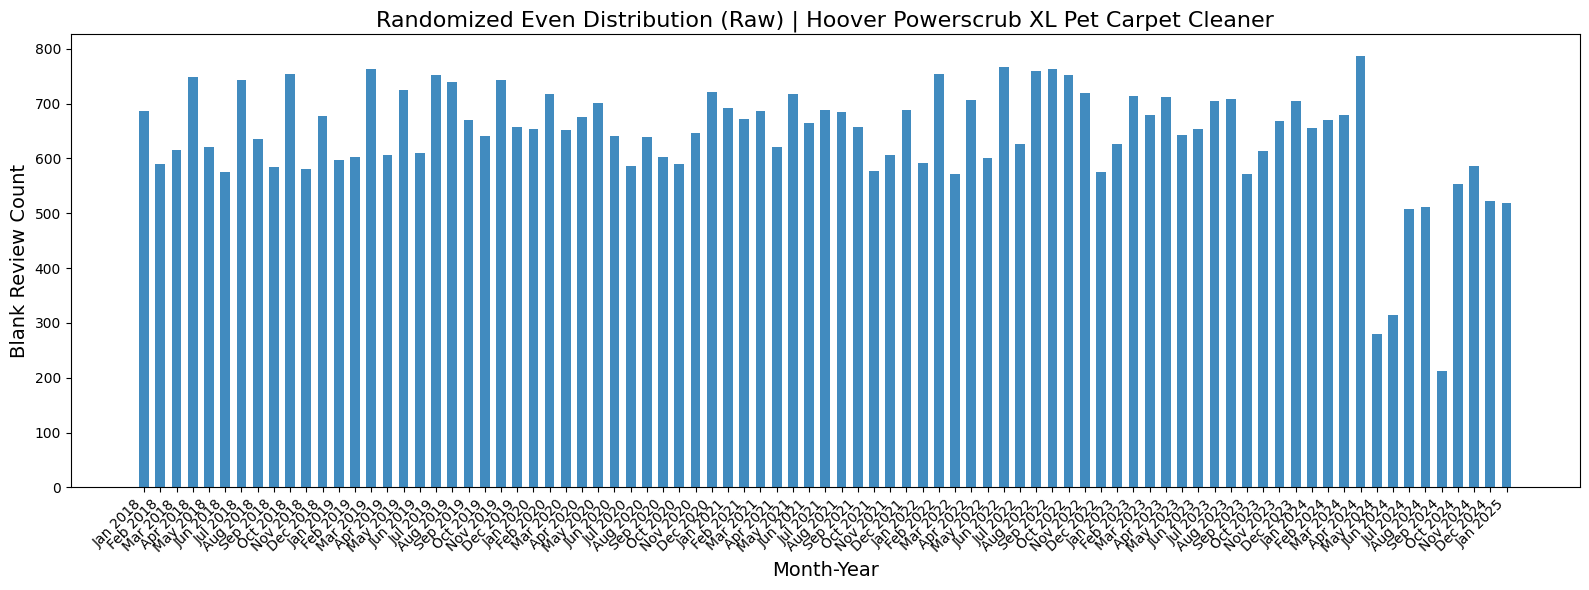

/var/folders/w3/9m6t2b0n7rbfwxxh66jfqx8c0000gn/T/ipykernel_88144/73701677.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_sum['Month_Year_dt'] = pd.to_datetime(monthly_sum['Month_Year'])


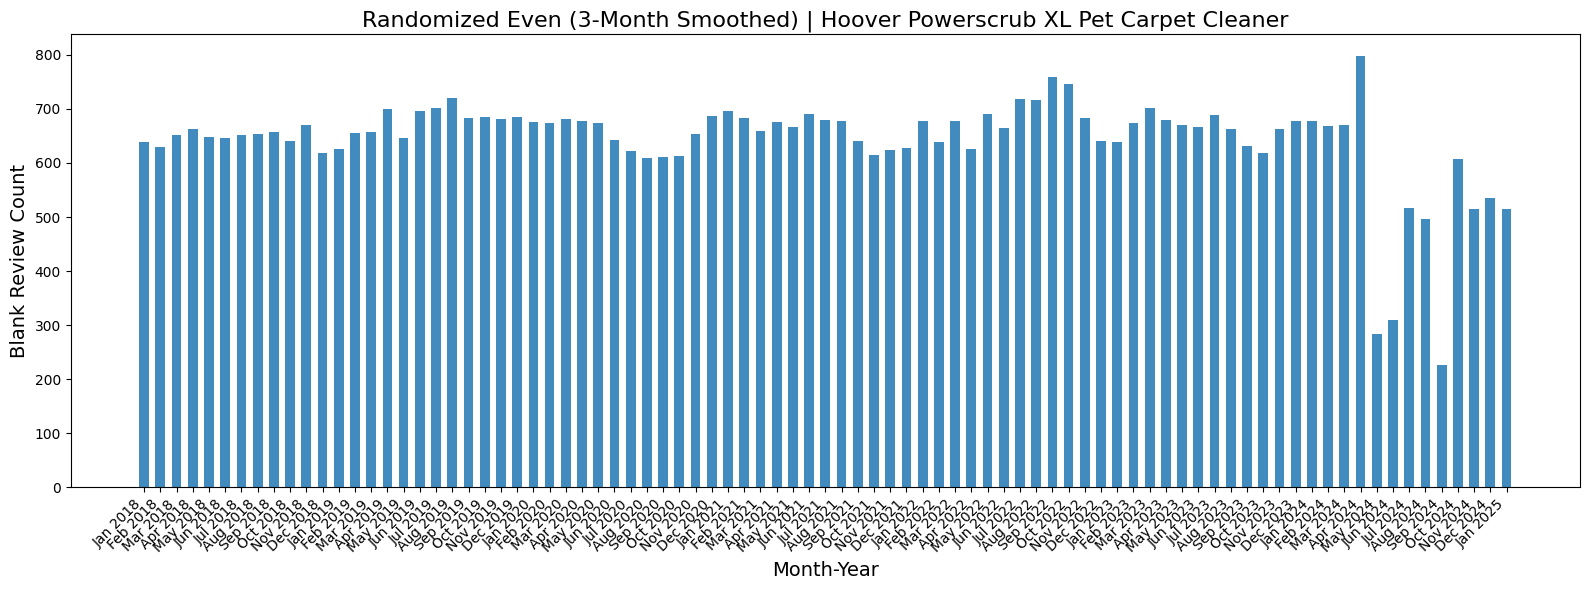

/var/folders/w3/9m6t2b0n7rbfwxxh66jfqx8c0000gn/T/ipykernel_88144/73701677.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_sum['Month_Year_dt'] = pd.to_datetime(monthly_sum['Month_Year'])


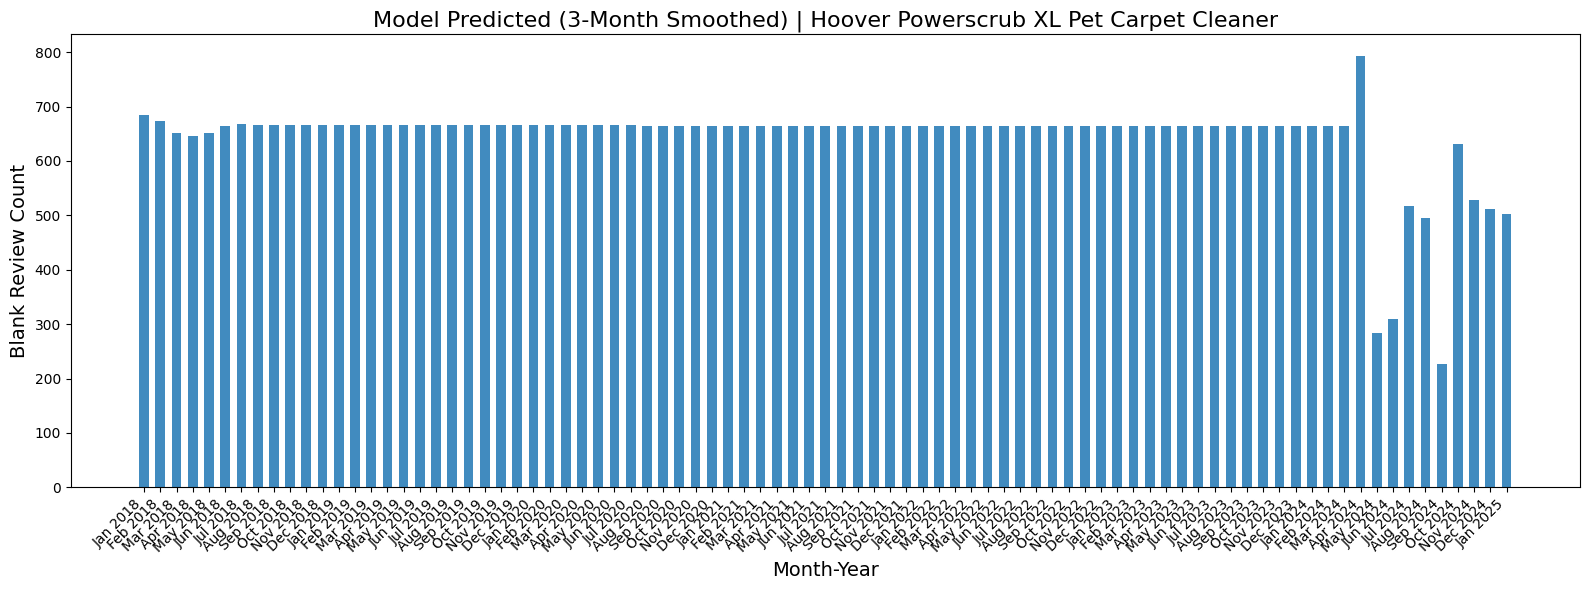

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'Month' is datetime
monthly_pred_df['Month'] = pd.to_datetime(monthly_pred_df['Month'])
# Add 'Month_Year' column as string, e.g. "Jan 2025"
monthly_pred_df['Month_Year'] = monthly_pred_df['Month'].dt.strftime('%b %Y')

plot_configs = [
    {'col': 'Blank_Review_Raw', 'title': "Randomized Even Distribution (Raw)"},
    {'col': 'Blank_Review_RawSmoothed', 'title': "Randomized Even (3-Month Smoothed)"},
    {'col': 'Blank_Review_ModelSmoothed', 'title': "Model Predicted (3-Month Smoothed)"},
]

for product, prod_group in monthly_pred_df.groupby('Product_Name'):
    for config in plot_configs:
        # Group by Month_Year and sum over all delta periods
        monthly_sum = prod_group.groupby('Month_Year')[config['col']].sum().reset_index()
        # Sort months chronologically
        monthly_sum['Month_Year_dt'] = pd.to_datetime(monthly_sum['Month_Year'])
        monthly_sum = monthly_sum.sort_values('Month_Year_dt')

        plt.figure(figsize=(16, 6))
        plt.bar(monthly_sum['Month_Year'], monthly_sum[config['col']], width=0.6, color='tab:blue', alpha=0.85)
        plt.title(f"{config['title']} | {product}", fontsize=16)
        plt.xlabel("Month-Year", fontsize=14)
        plt.ylabel("Blank Review Count", fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
